# 뗑컨 몸무게 예측 경진대회

## 패키지 import 및 데이터 전처리

In [272]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/train.csv')

In [6]:
df.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [7]:
df.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [8]:
df.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거 

In [9]:
df.isnull().sum()

Species           0
Island            0
Full_Clutch       0
Culmen_Length     0
Culmen_Depth      0
Flipper_Length    0
Sex               3
DeltaN            3
DeltaC            3
Body_Mass         0
dtype: int64

`-` Sex, Delta 15 N, Delta 13 C 컬럼에 결측치가 3개씩 존재한다

In [10]:
## 결측치가 있는 row들을 확인
df[df.isna().sum(axis = 1) > 0]

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Body_Mass
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
18,Adelie Penguin (Pygoscelis adeliae),Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650
70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650
109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700


`-` 방사성 동위원소 행의 결측치에는 평균값을 넣어주자

In [11]:
df['DeltaC'].fillna(df['DeltaC'].mean(), inplace = True)
df['DeltaN'].fillna(df['DeltaN'].mean(), inplace = True)

`-` EDA를 보면 알겠지만 Species별로 몸무게가 다르다

`-` 또한 수컷과 암컷간의 차이도 꽤 있다

`-` drop해도 되지만 3개의 데이터가 유실되는 것이기에 Species와 Body_Mass를 통해 결측치에 값을 채워넣자

In [12]:
df.groupby(['Species', 'Sex']).\
agg({'Body_Mass':np.mean}).reset_index()

,Species,Sex,Body_Mass
0,Adelie Penguin (Pygoscelis adeliae),FEMALE,3448.611111
1,Adelie Penguin (Pygoscelis adeliae),MALE,4097.619048
2,Chinstrap penguin (Pygoscelis antarctica),FEMALE,3550.000000
3,Chinstrap penguin (Pygoscelis antarctica),MALE,4018.181818
4,Gentoo penguin (Pygoscelis papua),FEMALE,4707.608696
5,Gentoo penguin (Pygoscelis papua),MALE,5445.833333


`-` 6번 펭귄의 성별은 수컷, 8번은 암컷, 70번은 암컷으로 하자

In [13]:
df.loc[[6,8,70], 'Sex']= ['MALE','FEMALE', 'FEMALE']

`-` 이상으로 결측치 처리는 끝났다

In [15]:
df.isnull().sum().sum() ## 이제 결측치는 없다

0

## 모델링

### 전처리

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
dt = df.iloc[:, :-1]      ## target 제외한 데이터프레임
target = df['Body_Mass']  ## target

`-` 범주형 변수에 라벨인코딩을 해주자

In [18]:
from sklearn.preprocessing import LabelEncoder

dt2 = dt.copy()
for col in dt2.columns:
    if dt2.dtypes[col] == 'O':
        encoder = LabelEncoder()
        encoder.fit(dt2[col])
        labels = encoder.transform(dt2[col])
        dt2[col] = list(labels) 

In [19]:
dt2.head()  ## 라벨 인코딩이 잘 되었다

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
1,1,1,0,49.5,19.0,200,1,9.63074,-24.34684
2,2,0,1,45.1,14.4,210,0,8.51951,-27.01854
3,2,0,1,44.5,14.7,214,0,8.20106,-26.16524
4,2,0,0,49.6,16.0,225,1,8.38324,-26.84272


In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(dt2, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt2['Species'] , random_state = 21)
## 종의 비율이 train, valid 비슷하도록 세팅함

`-` 위의 split한 데이터프레임을 reset_index 하게 되면 기존의 인덱스번호가 초기화됨을 잊지말자 

## 랜덤 포레스트

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
def RMSE(real, predict):
    return np.sqrt(np.mean(np.square(real - predict)))

In [23]:
model = RandomForestRegressor(random_state = 21)     ## 랜덤 포레스트 모델 선언
model.fit(x_train, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(x_valid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 258.90741903320344


`-` RMSE는 약 258이다

### 모델 성능 시각화

In [24]:
import matplotlib.pyplot as plt

In [25]:
y_predict[:6]

array([3571.75, 3961.25, 3345.75, 5532.  , 3995.5 , 3329.75])

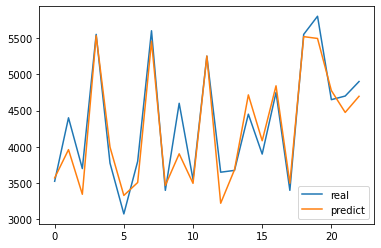

In [26]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` 그럭저럭 잘 맞추는 것 같다

### feature 중요도 시각화

`-` feature_importances를 담은 데이터프레임을 만들자

In [27]:
model.feature_importances_

array([0.30032091, 0.00225925, 0.0048286 , 0.04858699, 0.07117125,
       0.43664406, 0.06611859, 0.03603486, 0.03403549])

In [28]:
x_train.columns

Index(['Species', 'Island', 'Full_Clutch', 'Culmen_Length', 'Culmen_Depth',
       'Flipper_Length', 'Sex', 'DeltaN', 'DeltaC'],
      dtype='object')

In [31]:
importance = pd.DataFrame({'col_name':x_train.columns, 'importance':model.feature_importances_})
importance

,col_name,importance
0,Species,0.300321
1,Island,0.002259
2,Full_Clutch,0.004829
3,Culmen_Length,0.048587
4,Culmen_Depth,0.071171
5,Flipper_Length,0.436644
6,Sex,0.066119
7,DeltaN,0.036035
8,DeltaC,0.034035


<AxesSubplot:ylabel='col_name'>

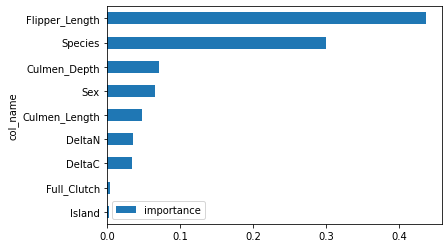

In [32]:
importance.sort_values('importance', ascending = True).\
set_index('col_name').\
plot.barh()

`-` 일단 중요도들의 합은 $1$이다

`-` Island와 Full_Cluth 변수는 중요도가 거의 $0$이다

`-` 중요도가 거의 $0$인 변수를 제외하고 랜덤 포레스트 모델을 만들어보자

## 랜덤 포레스트 (중요하지 않은 변수 제거)

In [33]:
## 중요도가 거의 0인 feature와 방사성 동위원소 feature 제거
Xtrain = x_train.drop(['Full_Clutch', 'Island', 'DeltaN', 'DeltaC'], axis = 1)
Xvalid = x_valid.drop(['Full_Clutch', 'Island', 'DeltaN', 'DeltaC'], axis = 1)

In [34]:
model = RandomForestRegressor(random_state = 21)     ## 랜덤 포레스트 모델 선언
model.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 282.3476888364846


### 모델 성능 시각화

In [35]:
y_predict[:6]

array([3594.25, 3945.75, 3160.75, 5487.  , 3908.75, 3284.  ])

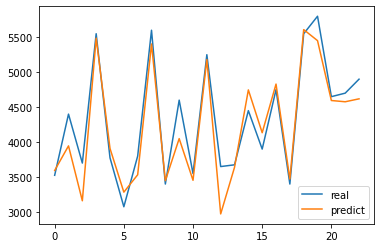

In [36]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` 그럭저럭 잘 맞추는 것 같다

## 랜덤 포레스트 (Species, Flipper_Length 선택)

In [37]:
Xtrain = x_train[['Species', 'Flipper_Length']]
Xvalid = x_valid[['Species', 'Flipper_Length']]

In [38]:
model = RandomForestRegressor(random_state = 21)     ## 랜덤 포레스트 모델 선언
model.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 405.8250980015842


### 모델 성능 시각화

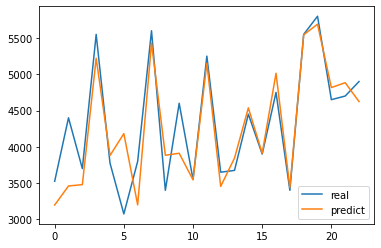

In [39]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` 변수를 2개만 사용하니 성능이 더 안좋아졌다

`-` 언더피팅 되었다

## 랜덤 포레스트 하이퍼 파라미터 변경

### Species, Flipper_Length, Sex 사용

In [199]:
Xtrain = x_train[['Species', 'Flipper_Length', 'Sex']]
Xvalid = x_valid[['Species', 'Flipper_Length', 'Sex']]

In [200]:
model_3N = RandomForestRegressor(random_state = 21,
                              min_samples_leaf = 7,
                              min_samples_split = 15,
                              max_depth = 4)     ## 랜덤 포레스트 모델 선언
model_3N.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model_3N.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 236.6482183459694


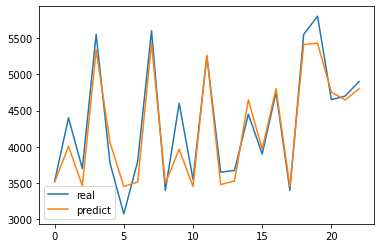

In [201]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` Sex 변수를 추가하니 성능이 더 좋아졌다

In [202]:
model_3N.feature_importances_

array([0.3588999 , 0.51824795, 0.12285215])

In [203]:
Xtrain.columns

Index(['Species', 'Flipper_Length', 'Sex'], dtype='object')

In [204]:
importance = pd.DataFrame({'col_name':Xtrain.columns, 'importance':model_3N.feature_importances_})

<AxesSubplot:ylabel='col_name'>

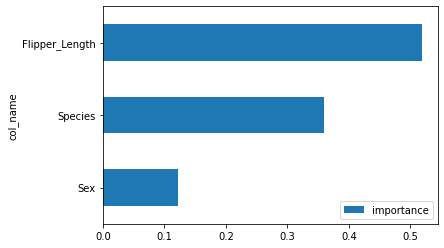

In [205]:
importance.sort_values('importance', ascending = True).\
set_index('col_name').\
plot.barh()

### Island, Full_Clutch, DeltaN, DeltaC 제거

`-` 방사성 동위원소 피쳐를 남기고 랜덤 포레스트를 만들어봤는데 중요도가 $0$이 됐다

In [188]:
Xtrain = x_train.drop(['Island', 'Full_Clutch', 'DeltaN', 'DeltaC'], axis = 1)
Xvalid = x_valid.drop(['Island', 'Full_Clutch', 'DeltaN', 'DeltaC'], axis = 1)

In [189]:
model = RandomForestRegressor(random_state = 21,
                              min_samples_leaf = 7,
                              min_samples_split = 14,
                              max_depth = 3)     ## 랜덤 포레스트 모델 선언
model.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)    ## 평가 지수 
print('RMSE', rmse)

RMSE 250.4720397172584


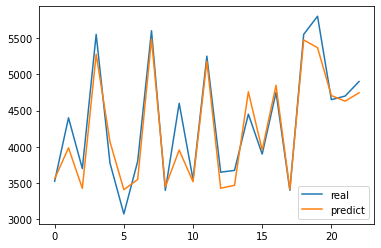

In [190]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

In [191]:
importance = pd.DataFrame({'col_name':Xtrain.columns, 'importance':model.feature_importances_})

<AxesSubplot:ylabel='col_name'>

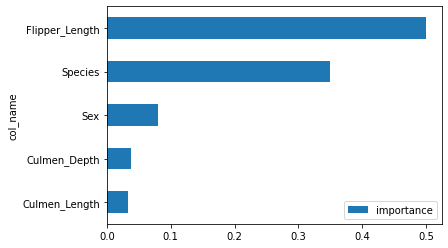

In [192]:
importance.sort_values('importance', ascending = True).\
set_index('col_name').\
plot.barh()

### test 데이터 예측

`-` Species, Flipper_Length, Sex를 사용한 랜덤포레스트 모델로 test 데이터셋을 예측하자

In [193]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [194]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

`-` test 데이터에 NA가 존재하나 Species, Flipper_Length만 사용할 것이므로 괜찮다

In [195]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

`-` test 셋에서 범주형 변수에 라벨인코딩을 해주자

In [196]:
test2 = test.copy()
for col in test2.columns:
    if test2.dtypes[col] == 'O':
        encoder = LabelEncoder()
        encoder.fit(test2[col])
        labels = encoder.transform(test2[col])
        test2[col] = list(labels) 

In [197]:
test2.head()  ## 라벨 인코딩이 잘 되었다

,id,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,0,1,1,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,1,2,0,1,55.9,17.0,228.0,1,8.31180,-26.35425
2,2,0,1,1,38.9,18.8,190.0,0,8.36936,-26.11199
3,3,1,1,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,4,0,0,0,37.9,18.6,172.0,0,8.38404,-25.19837


In [198]:
test2 = test2[['Species', 'Flipper_Length', 'Sex']]

In [206]:
predict_test = model_3N.predict(test2)  ## 모델 예측

In [207]:
predict_test[:6]

array([4388.55855827, 5429.14121511, 3462.77933233, 3485.45232689,
       3452.43633413, 4049.73324955])

### dacon 대회에 제출하기

In [208]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [209]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4388.558558
1,1,5429.141215
2,2,3462.779332
3,3,3485.452327
4,4,3452.436334


In [212]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/뗑컨-몸무게-예측/Data/submission4.csv', index = False)

`-` 점수는 315.9755682384